# KBMOD Demo

The purpose of this demo is to showcase how KBMOD can be used to search through images for moving objects. The images used here are from the Subaru telescope and were processed using the LSST Science Pipelines.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from searchImage import searchImage
from analyzeImage import analyzeImage
%matplotlib inline
%load_ext autoreload
%autoreload 2

searchImage contains the tools for constructing the likelihood images and performing the KBMOD detection algorithm. It saves these results to file and analysis and identification of the objects takes place using the analyzeImage tools.

In [2]:
si = searchImage()

First we create a mask to use in the images. Since some moving objects are bright enough to be masked in some of the images we set a fraction of the images that a pixel has to be masked in order to add it to the master mask. Below that setting is 75% of the images.

In [3]:
mask = si.createMask('data_repo/chip_0/', 0.75)

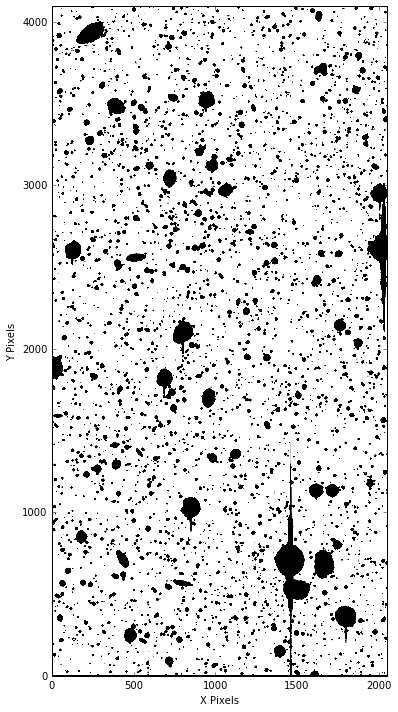

In [4]:
fig = plt.figure(figsize=(12,12))
plt.imshow(mask, origin='lower', cmap=plt.cm.Greys_r)
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

Next we use the mask and original images to build the Psi and Phi likelihood images.

In [5]:
psi_array, phi_array = si.calcPsiPhi('data_repo/chip_0', mask)

On Image CORR40535770.fits
On Image CORR40535780.fits
On Image CORR40535790.fits
On Image CORR40535800.fits
On Image CORR40535810.fits
On Image CORR40535820.fits
On Image CORR40535830.fits
On Image CORR40535840.fits
On Image CORR40535850.fits
On Image CORR40535860.fits
On Image CORR40535870.fits
On Image CORR40535880.fits
On Image CORR40535890.fits
On Image CORR40535900.fits
On Image CORR40535910.fits
On Image CORR40535920.fits
On Image CORR40535930.fits
On Image CORR40535940.fits
On Image CORR40535950.fits
On Image CORR40535960.fits
On Image CORR40535970.fits
On Image CORR40535980.fits
On Image CORR40535990.fits
On Image CORR40536000.fits
On Image CORR40536010.fits
On Image CORR40536020.fits
On Image CORR40536030.fits
On Image CORR40536040.fits
On Image CORR40536050.fits
On Image CORR40536060.fits
On Image CORR40536070.fits
On Image CORR40536080.fits
On Image CORR40536090.fits
On Image CORR40536100.fits
On Image CORR40536110.fits
On Image CORR40536120.fits
On Image CORR40536130.fits
O

Here we calculate the image time from the header and also load the MJD values of each image in order to calculate orbit details later.

In [6]:
image_times, image_mjd = si.loadImageTimes('data_repo/chip_0')

Finally, we load the images themselves with the mask on top in order to build the postage stamps we will use to look at the potential objects we discover.

In [7]:
im_array = si.loadMaskedImages('data_repo/chip_0', mask)

On Image CORR40535770.fits
On Image CORR40535780.fits
On Image CORR40535790.fits
On Image CORR40535800.fits
On Image CORR40535810.fits
On Image CORR40535820.fits
On Image CORR40535830.fits
On Image CORR40535840.fits
On Image CORR40535850.fits
On Image CORR40535860.fits
On Image CORR40535870.fits
On Image CORR40535880.fits
On Image CORR40535890.fits
On Image CORR40535900.fits
On Image CORR40535910.fits
On Image CORR40535920.fits
On Image CORR40535930.fits
On Image CORR40535940.fits
On Image CORR40535950.fits
On Image CORR40535960.fits
On Image CORR40535970.fits
On Image CORR40535980.fits
On Image CORR40535990.fits
On Image CORR40536000.fits
On Image CORR40536010.fits
On Image CORR40536020.fits
On Image CORR40536030.fits
On Image CORR40536040.fits
On Image CORR40536050.fits
On Image CORR40536060.fits
On Image CORR40536070.fits
On Image CORR40536080.fits
On Image CORR40536090.fits
On Image CORR40536100.fits
On Image CORR40536110.fits
On Image CORR40536120.fits
On Image CORR40536130.fits
O

We also need the wcs for the images.

In [8]:
wcs_list = si.loadWCSList('data_repo/chip_0')

Our algorithm uses the PSF kernel from the LSST data management pipeline, but below we show that is it comparable to a 2-d Gaussian with a sigma of 1 pixel.

In [9]:
psf_array = si.loadPSF('data_repo/chip_0')

In [10]:
from createImage import createImage as ci
#Create a 2-d Gaussian with sigma 1 pixel in x and y directions and in the center of a 41 x 41 pixel grid with
#total flux equal to 1.0
gauss2d = ci().createGaussianSource([20., 20.], [1., 1.], [41., 41.], 1.)

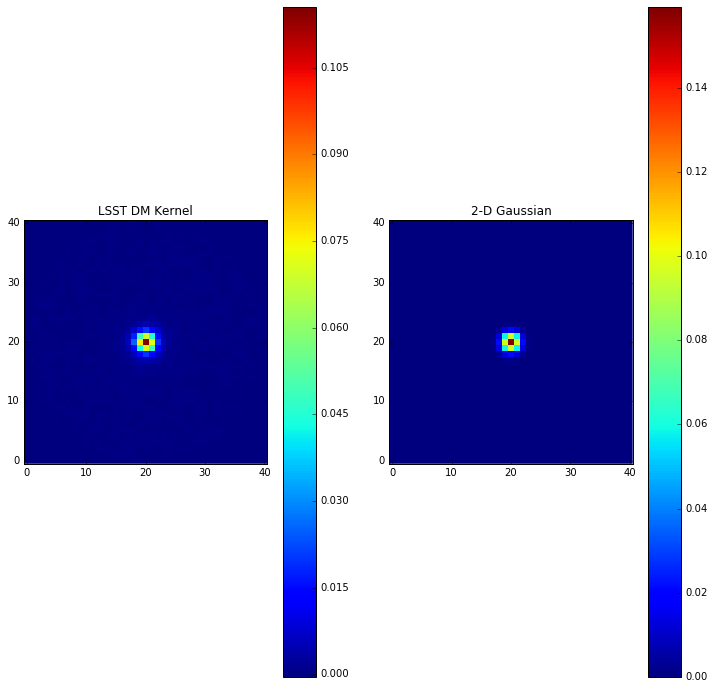

In [11]:
fig = plt.figure(figsize=(12,12))
fig.add_subplot(1,2,1)
plt.imshow(psf_array[0], origin='lower', interpolation='None')#, vmin = -111, vmax = 119, cmap=plt.cm.Greys_r)
plt.title('LSST DM Kernel')
plt.colorbar()
fig.add_subplot(1,2,2)
plt.imshow(gauss2d, origin='lower', interpolation='None')
plt.title('2-D Gaussian')
plt.colorbar()

Here we set up a grid of angles from the ecliptic of -15 to 15 degrees and velocities ranging from 0.4 to 4.5 arcsec per hour in order to line up with the grid used in [Fraser and Kavelaars (2009)](http://adsabs.harvard.edu/abs/2009AJ....137...72F).

In [12]:
angles = [-15., -7.5, 0, 7.5, 15]
rates = np.arange(0.4, 4.5, .2277)
para_steps = []
perp_steps = []
for rate in rates:
    for angle in angles:
        para_steps.append(rate*np.cos(np.radians(angle)))
        perp_steps.append(rate*np.sin(np.radians(angle)))
para_steps = -1.*np.array(para_steps)
perp_steps = np.array(perp_steps)

We currently have trouble with slower trajectories so we set a lower bound on the velocity for the demo.

In [13]:
para_fast = para_steps[45:]
perp_fast = perp_steps[45:]

In [14]:
vel_grid = np.array([para_fast, perp_fast]).T

We now have everything we need set up to begin searching in likelihood space for the images. We use the method findObjectsEcliptic now. Below we are setup to search a section of the images between pixels 1024 and 2048 in both the x and y axes.

In order to filter out results that start in the same place and travel along similar trajectories we cluster results in a 4-dimensional space: x starting position, y starting position, total velocity and slope. 

In [15]:
x_quad_size = 1024
y_quad_size = 1024
x_offset = 1024
y_offset = 1024
quad_results = {}
for quadrant_x in range(0,1):
    for quadrant_y in range(0,1):
        x_range = [x_offset+x_quad_size*quadrant_x, x_offset+x_quad_size*(quadrant_x+1)]
        y_range = [y_offset+y_quad_size*quadrant_y, y_offset+y_quad_size*(quadrant_y+1)]
        topResults = si.findObjectsEcliptic(psi_array, # The psi images
                                            phi_array, # The phi images
                                            vel_grid, # The velocity search grid
                                            2.0, # The likelihood threshold
                                            image_times, # The times after image 1, each image was taken.
                                            [wcs_list[0]]*55, # The wcs values
                                            xRange = x_range, # The x pixel coordinate range
                                            yRange = y_range, # The y pixel coordinate range
                                            out_file='results/chip_0/quad_%i_%i_test_test.txt' % (quadrant_x, quadrant_y))

Starting Search
10.0 percent searched.
20.0 percent searched.
30.0 percent searched.
40.0 percent searched.
50.0 percent searched.
60.0 percent searched.
70.0 percent searched.
80.0 percent searched.
90.0 percent searched.
231379
100000
200000
0
Clustered 0 out of 231379
Clustered 100000 out of 231379
Clustered 200000 out of 231379
Down to 21 sources
Starting Positions: 
[[1693 1088]
 [1694 1088]
 [1692 1088]
 ..., 
 [1919 1156]
 [1483 1033]
 [1761 1102]]
Velocity Vectors: 
[[-3.02566606  0.81072478]
 [-3.02566606  0.81072478]
 [-3.02566606  0.81072478]
 ..., 
 [-2.36584213 -0.63392549]
 [-3.55710587 -0.46830187]
 [-3.78285787  0.49802269]]
Pixel Velocity Vectors: 
[[ 12.57705594   9.07369937]
 [ 12.57705594   9.07369937]
 [ 12.57705594   9.07369937]
 ..., 
 [ 12.06430208   1.22710823]
 [ 17.28625187   4.0888315 ]
 [ 16.63140278   8.95820325]]
Likelihood: 
[ 24.61269452  24.43932858  24.0260992  ...,   2.00001608   2.00001495
   2.00001453]
Best estimated flux: 
[ 436.62929149  443.944

/home-new/brycek/kbmod/code/searchImage.py:349: RuntimeWarning: invalid value encountered in sqrt
  nu_measurements[phi_not0] = psiTotal[phi_not0]/np.sqrt(phiTotal)[phi_not0]


Now we will load the results and try to find the best possible objects. For this we use the methods in analyzeImage.

In [17]:
results = np.genfromtxt('results/chip_0/quad_0_0_test_test.txt', names=True)

In [18]:
ai = analyzeImage()

We sort these results by the ratio of maximum brightness within an aperture centered on a coadded postage stamp along the trajectory to the maximum brightness outside of this aperture. A stationary unmasked object that is in the results will have a streak of fairly uniform brightness along the trajectory's slope in a coadded postage stamp while a moving object will have a bright center since the single images that make the coadd of a trajectory move along with the object.

In [38]:
best_targets = ai.sortCluster(results, im_array, image_times)
print best_targets

Done with Postage Stamps
[ 4  3  0 20  7 12 13 19 14  8  1  9]


Notice that the `best_targets` array that comes out of the sorting algorithm actually rearranged the results. Here we plot the most likely objects and see that the sorting algorithm gave us an actual asteroid as the most likely object while the highest likelihood object was moved down the rankings (the `best_targets` output above shows it is the third in the images below).

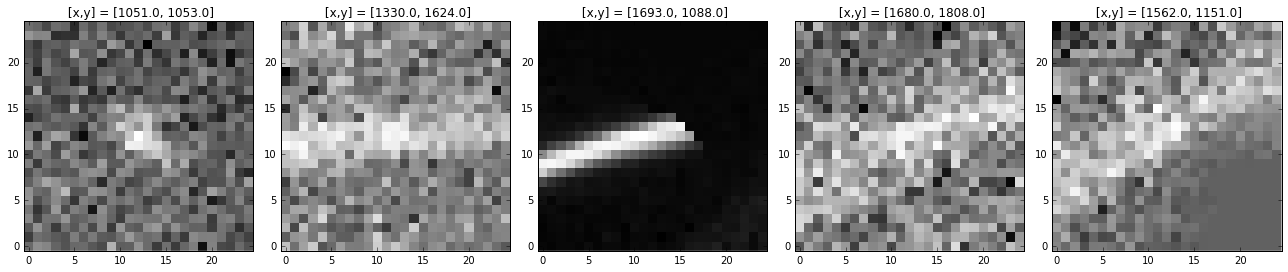

In [32]:
fig = plt.figure(figsize=(18,12))
i=0
for imNum in range(5):
    fig.add_subplot(1,5,imNum+1)
    try:
        plt.imshow(ai.createPostageStamp(im_array, 
                                     list(results[['t0_x', 't0_y']][best_targets][imNum]),
                                     list(results[['v_x', 'v_y']][best_targets][imNum]),
                                     image_times, [25., 25.])[0],
                origin='lower', cmap=plt.cm.Greys_r, interpolation='None')
        plt.title(str(' [x,y] = ' + str(list(results[['t0_x', 't0_y']][best_targets][imNum]))))
    except:
        continue
plt.tight_layout()

We have also written methods to plot information related to a trajectory. Below we plot its path through one of the images and its light curve.

In [33]:
return_result = best_targets[0]

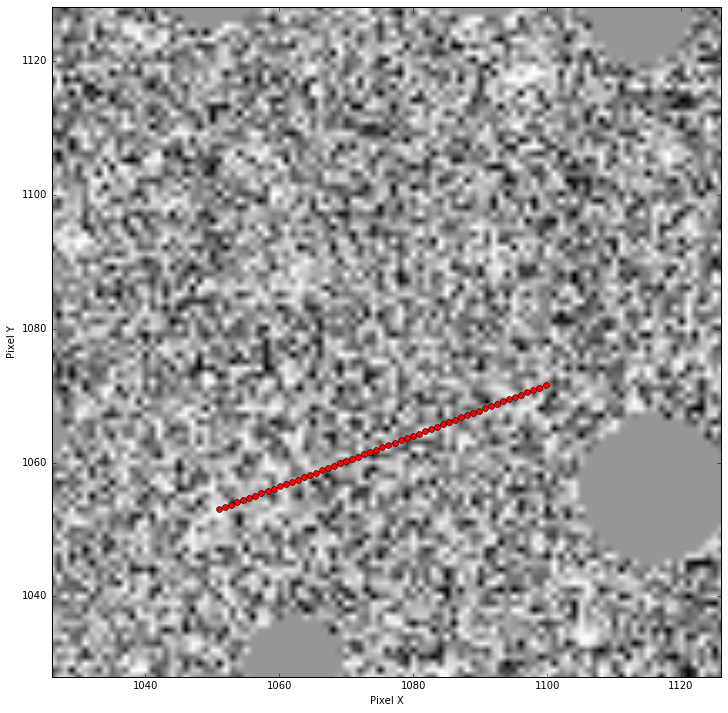

In [34]:
fig = plt.figure(figsize=(12,12))
ax = ai.plotTrajectory(results[return_result], 
                        image_times, im_array[0], im_plot_args={'vmin':-111, 'vmax':111})
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

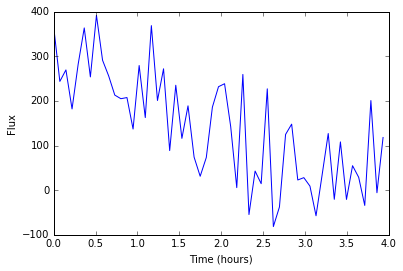

In [35]:
fig = plt.figure()
ax = ai.plotLightCurves(im_array, results[return_result], image_times)

Finally, we can output the coordinates of the object throughout its trajectory and use this as input to orbit fitting software such as that of [Bernstein and Khushalani (2000)](http://iopscience.iop.org/article/10.1086/316868/fulltext/200298.text.html).

In [36]:
test_coords = ai.return_ra_dec(np.array(list(results[['t0_x', 't0_y']][return_result])),
                               np.array(list(results[['v_x', 'v_y']][return_result])), 
                               image_times, image_mjd, wcs_list[0], np.ones(len(image_times))*.1, 568)

In [37]:
test_coords

array(['2454213.8350  13:47:56.1745  -10:40:19.1768  0.10  568',
       '2454213.8381  13:47:56.1621  -10:40:19.1072  0.10  568',
       '2454213.8411  13:47:56.1497  -10:40:19.0381  0.10  568',
       '2454213.8442  13:47:56.1373  -10:40:18.9688  0.10  568',
       '2454213.8472  13:47:56.1249  -10:40:18.8994  0.10  568',
       '2454213.8502  13:47:56.1126  -10:40:18.8304  0.10  568',
       '2454213.8533  13:47:56.1001  -10:40:18.7609  0.10  568',
       '2454213.8563  13:47:56.0878  -10:40:18.6920  0.10  568',
       '2454213.8594  13:47:56.0754  -10:40:18.6227  0.10  568',
       '2454213.8624  13:47:56.0630  -10:40:18.5536  0.10  568',
       '2454213.8654  13:47:56.0506  -10:40:18.4842  0.10  568',
       '2454213.8685  13:47:56.0383  -10:40:18.4152  0.10  568',
       '2454213.8715  13:47:56.0259  -10:40:18.3461  0.10  568',
       '2454213.8745  13:47:56.0135  -10:40:18.2768  0.10  568',
       '2454213.8776  13:47:56.0012  -10:40:18.2078  0.10  568',
       '2454213.8806  13: